In [1]:
import os
os.environ['PYTENSOR_FLAGS'] = 'floatX=float32'

import sys 
from pyprojroot import here
sys.path.insert(0, str(here()))

import geopandas as gpd
from laos_gggi.data_functions import load_emdat_data, load_shapefile, load_rivers_data
from laos_gggi.plotting import configure_plot_style
from laos_gggi.statistics import get_distance_to_rivers
from laos_gggi.data_functions.combine_data import load_all_data
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import xarray as xr
import arviz as az
import scipy
import nutpie
import pathlib

import pymc as pm
import pytensor.tensor as pt
from laos_gggi.sample import sample_or_load

configure_plot_style()

In [4]:
def load_data(fpath):
    data = pd.read_csv(fpath)
    data['geometry'] = gpd.points_from_xy(data.long, data.lat)
    data = gpd.GeoDataFrame(data, crs='EPSG:4326')
    
    return data

folder = 'data'
modified_data = False
fpath_1 = here(os.path.join(folder, 'disaster_locations_gpt_repaired_w_features.csv'))
fpath_2 = here(os.path.join(folder, 'disaster_locations_gpt_repaired.csv'))
if os.path.exists(fpath_1):
    data = load_data(fpath_1)
elif os.path.exists(fpath_2):
    data = load_data(fpath_2)
else:
    raise ValueError('Go run the GPT notebook first!')

In [5]:
#Load Laos shapefile
laos = load_shapefile('laos')

In [6]:
#Load data
emdat = load_emdat_data()

In [7]:
data = (data
            .set_index(['emdat_index'])
            .join(emdat['df_raw_filtered_adj'])
            .reset_index(drop=False)
            .rename(columns={'index':'emdat_index'})
            .set_index(['emdat_index', 'location_id'])
       )

In [8]:
world = load_shapefile('world')
laos = load_shapefile('laos')
coastline = load_shapefile('coastline')
rivers = load_rivers_data()

/tmp/ipykernel_495027/3914288617.py:4: DeprecationWarning: URLopener style of invoking requests is deprecated. Use newer urlopen functions/methods
  rivers = load_rivers_data()


<Axes: >

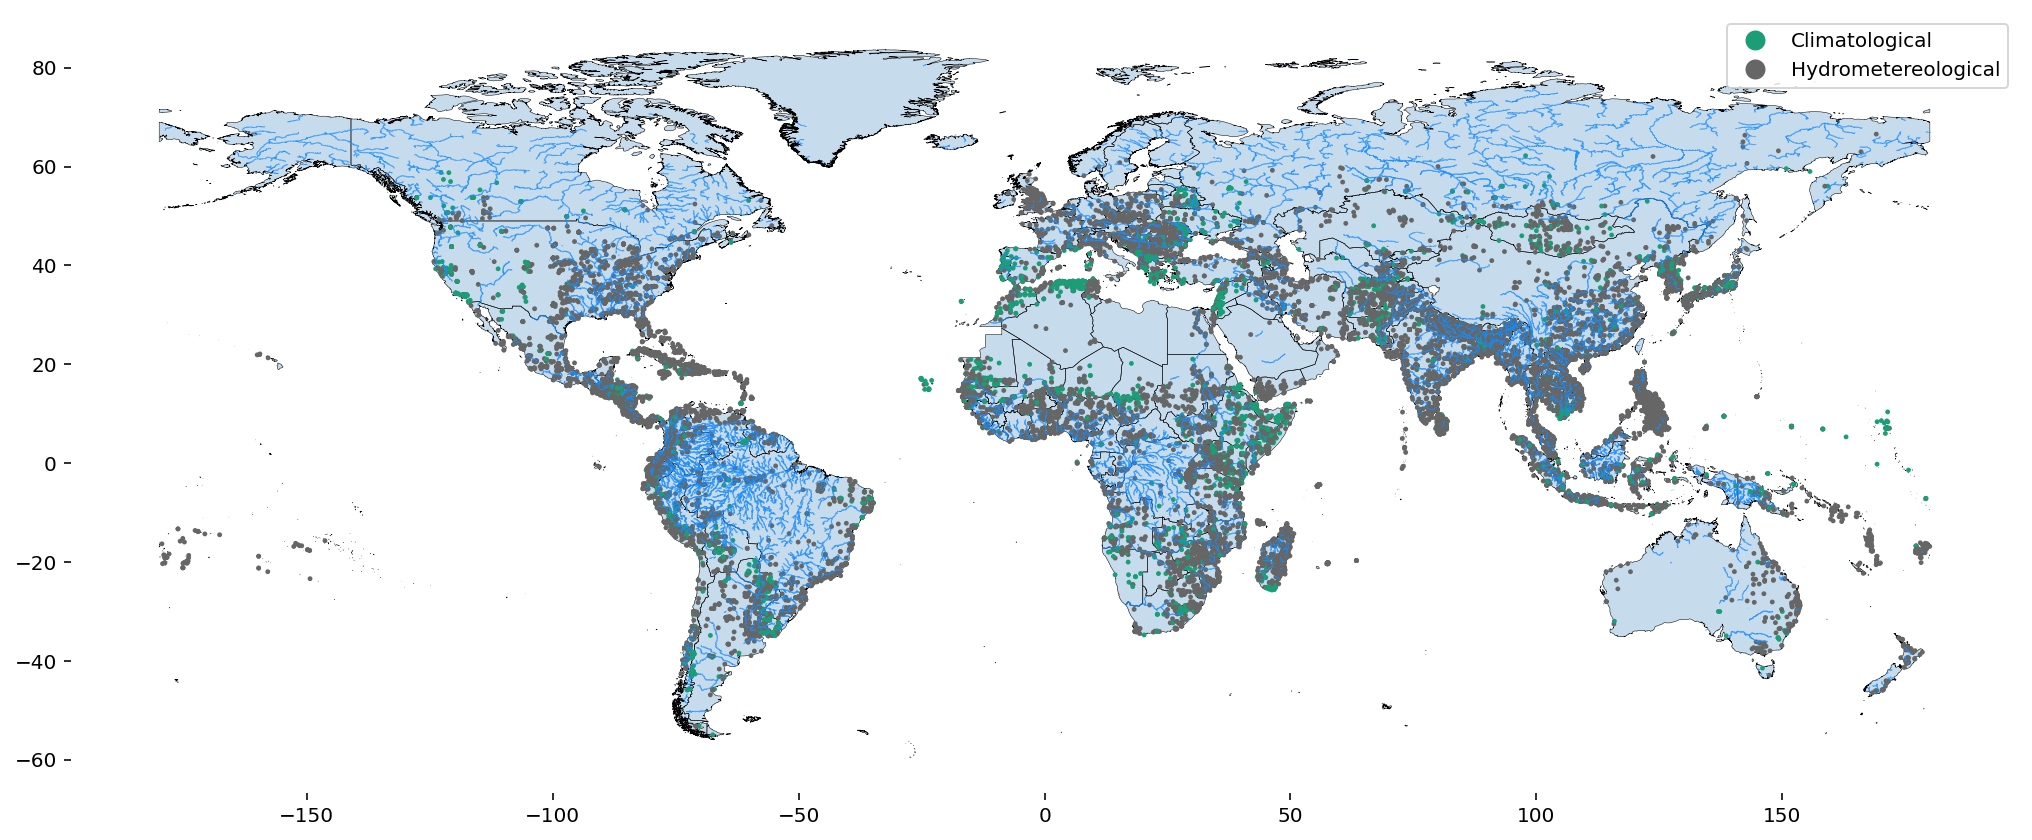

In [9]:
fig, ax = plt.subplots(figsize=(14, 9), dpi=144)
world.plot(facecolor='tab:blue', alpha=0.25, ax=ax)
world.plot(facecolor='none', edgecolor='k', lw=0.25, ax=ax)
rivers.plot(edgecolor='dodgerblue', lw=0.5, ax=ax)
data.dropna(subset='disaster_class').plot('disaster_class', markersize=2, ax=ax, legend=True, cmap='Dark2')

In [10]:
from joblib import Parallel, delayed
import pandas as pd
from tqdm.notebook import tqdm

def get_distance_to(gdf, points, return_columns=None, crs="EPSG:3395", n_cores=-1):
    if return_columns is None:
        return_columns = []
        
    gdf_km = gdf.copy().to_crs(crs)
    points_km = points.copy().to_crs(crs)
    
    def get_closest(idx, row, gdf_km, return_columns):
        series = gdf_km.distance(row.geometry)
        index = series[series == series.min()].index[0]

        ret_vals = (series.min(), )
        for col in return_columns:
            ret_vals += (gdf_km.loc[index][col], )
        
        return ret_vals
    
    with Parallel(n_cores, require='sharedmem') as pool:
        results = pool(delayed(get_closest)(idx, row, gdf_km, return_columns) for idx, row in tqdm(points_km.iterrows(), total=points.shape[0]))
    return pd.DataFrame(results, columns = ['distance_to_closest'] + return_columns, index=points.index)

In [11]:
if 'distance_to_river' not in data.columns:
    distances = get_distance_to(rivers, points=data, return_columns=['ORD_FLOW', 'HYRIV_ID']).rename(columns={'distance_to_closest':'distance_to_river'})
    data = data.join(distances).assign(distance_to_river = lambda x: x.distance_to_river / 1000)
    modified_data = True

<Axes: ylabel='Frequency'>

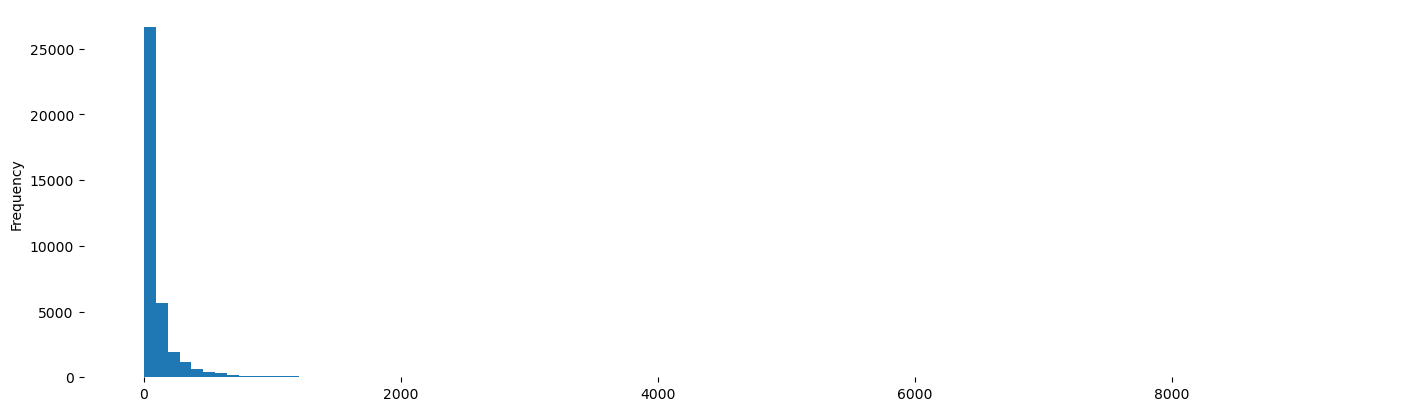

In [12]:
data.distance_to_river.plot.hist(bins=100)

In [13]:
if 'distance_to_coastline' not in data.columns:
    distances = get_distance_to(coastline.boundary, points=data.loc[:, ['geometry']]).rename(columns={'distance_to_closest':'distance_to_coastline'})
    data = data.join(distances).assign(distance_to_coastline = lambda x: x.distance_to_coastline / 1000)
    modified_data = True

<Axes: ylabel='Frequency'>

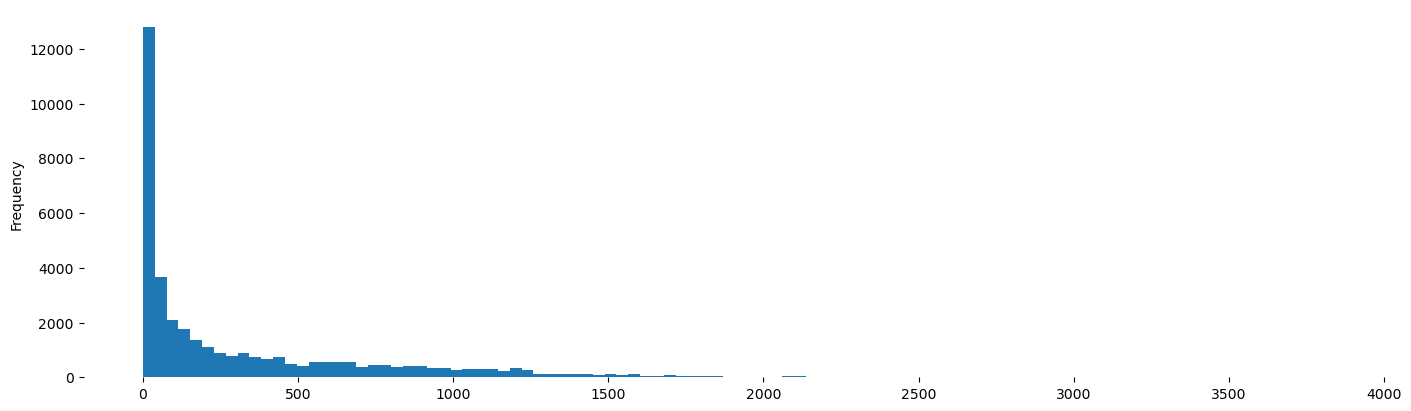

In [14]:
data.distance_to_coastline.plot.hist(bins=100)

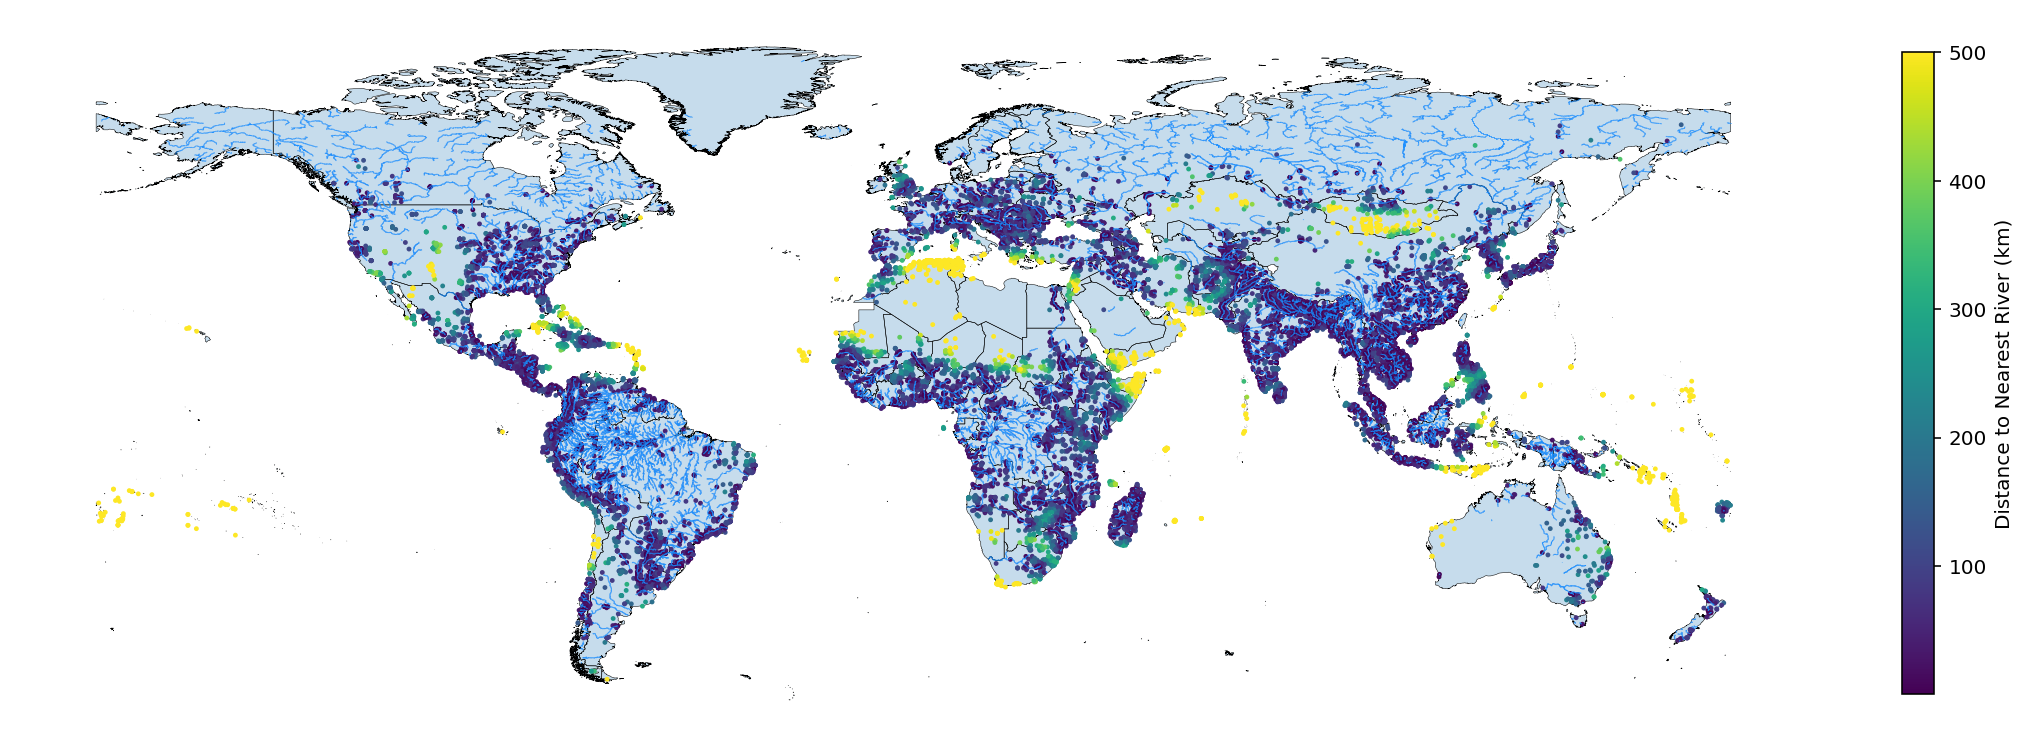

In [15]:
fig, ax = plt.subplots(figsize=(14, 9), dpi=144)
world.plot(facecolor='tab:blue', alpha=0.25, ax=ax)
world.plot(facecolor='none', edgecolor='k', lw=0.25, ax=ax)
rivers.plot(edgecolor='dodgerblue', lw=0.5, ax=ax)
data.dropna(subset='disaster_class').plot('distance_to_river', 
                                      markersize=2, 
                                      ax=ax, 
                                      legend=True, 
                                      cmap='viridis', 
                                      vmax=500, 
                                      legend_kwds={'shrink':0.5, 'label':'Distance to Nearest River (km)'})
ax.axis('off')
plt.show()

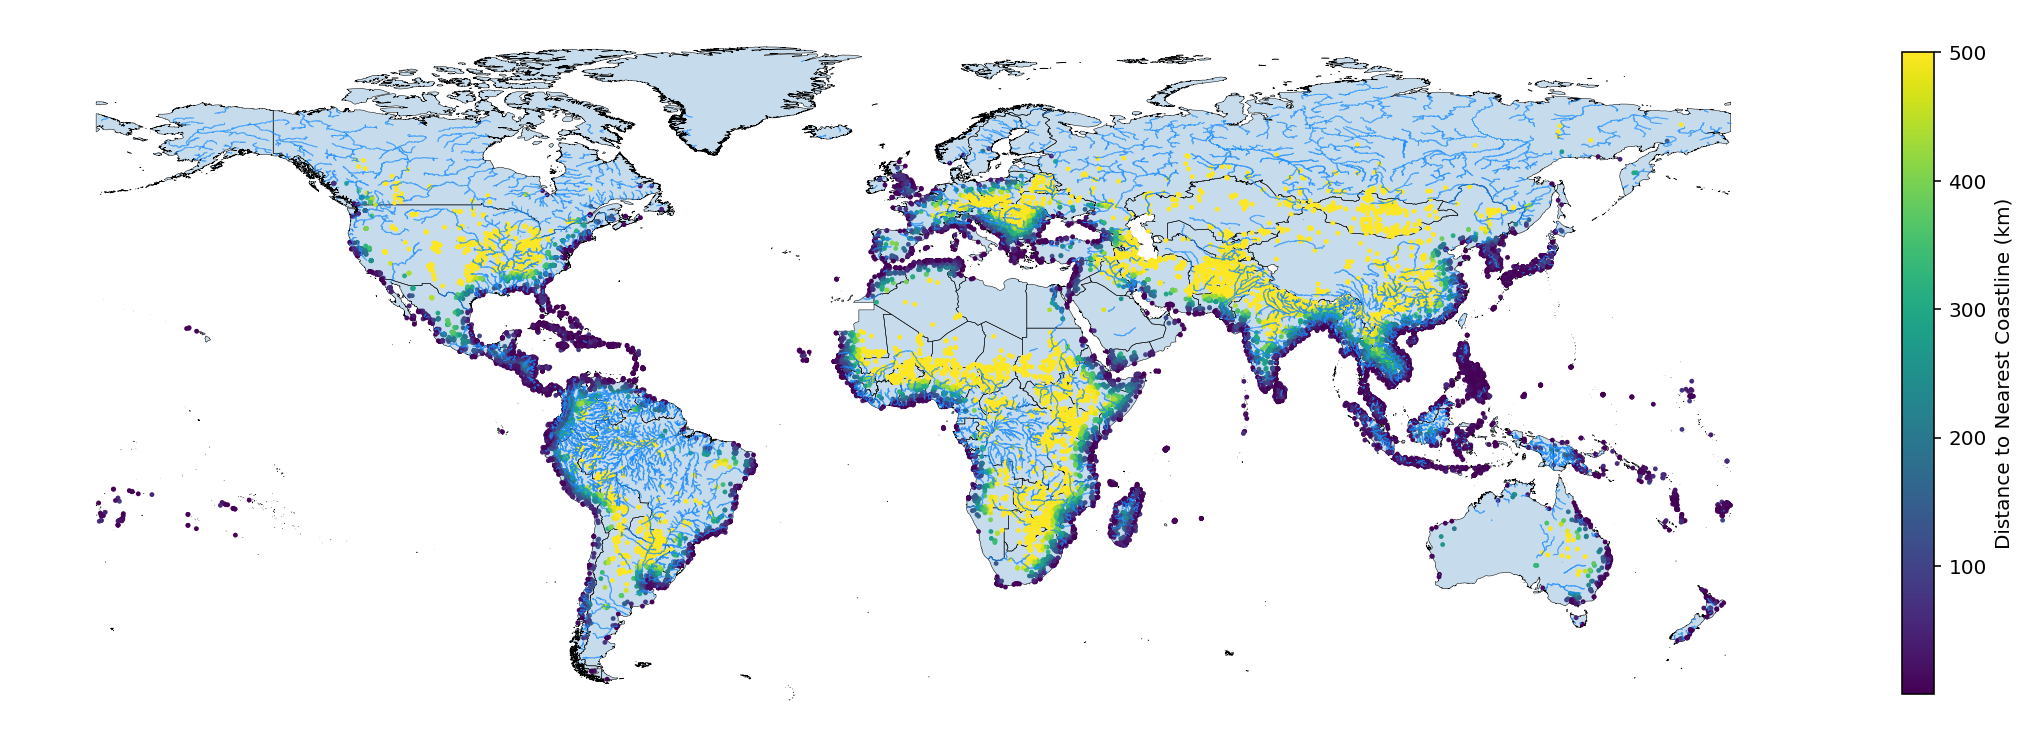

In [16]:
fig, ax = plt.subplots(figsize=(14, 9), dpi=144)
world.plot(facecolor='tab:blue', alpha=0.25, ax=ax)
world.plot(facecolor='none', edgecolor='k', lw=0.25, ax=ax)
rivers.plot(edgecolor='dodgerblue', lw=0.5, ax=ax)
data.dropna(subset='disaster_class').plot('distance_to_coastline', 
                                      markersize=2, 
                                      ax=ax, 
                                      legend=True, 
                                      cmap='viridis', 
                                      vmax=500,
                                      legend_kwds={'shrink':0.5, 'label':'Distance to Nearest Coastline (km)'})
ax.axis('off')
plt.show()

In [17]:
if 'is_island' not in data.columns:
    try:
        import wikipedia as wp
    except ImportError:
        !mamba install wikipedia -q -y
        import wikipedia as wp

    html = wp.page("List_of_island_countries").html().encode("UTF-8")
    island_table = (pd.read_html(html, skiprows=0)[0]
                        .droplevel(axis=1, level=0)
                        .dropna(how='all').iloc[1:]
                        .reset_index(drop=True)
                        .assign(ISO_2 = lambda x: x['ISO code'].str.split().str[0],
                                ISO_3 = lambda x: x['ISO code'].str.split().str[1].replace({'or':'GBR'}))
                   )
    data['is_island'] = data.ISO.isin(island_table.ISO_3)
    modified_data = True
    
island_dict = data.reset_index()[['ISO', 'is_island']].drop_duplicates().set_index('ISO')['is_island'].to_dict()

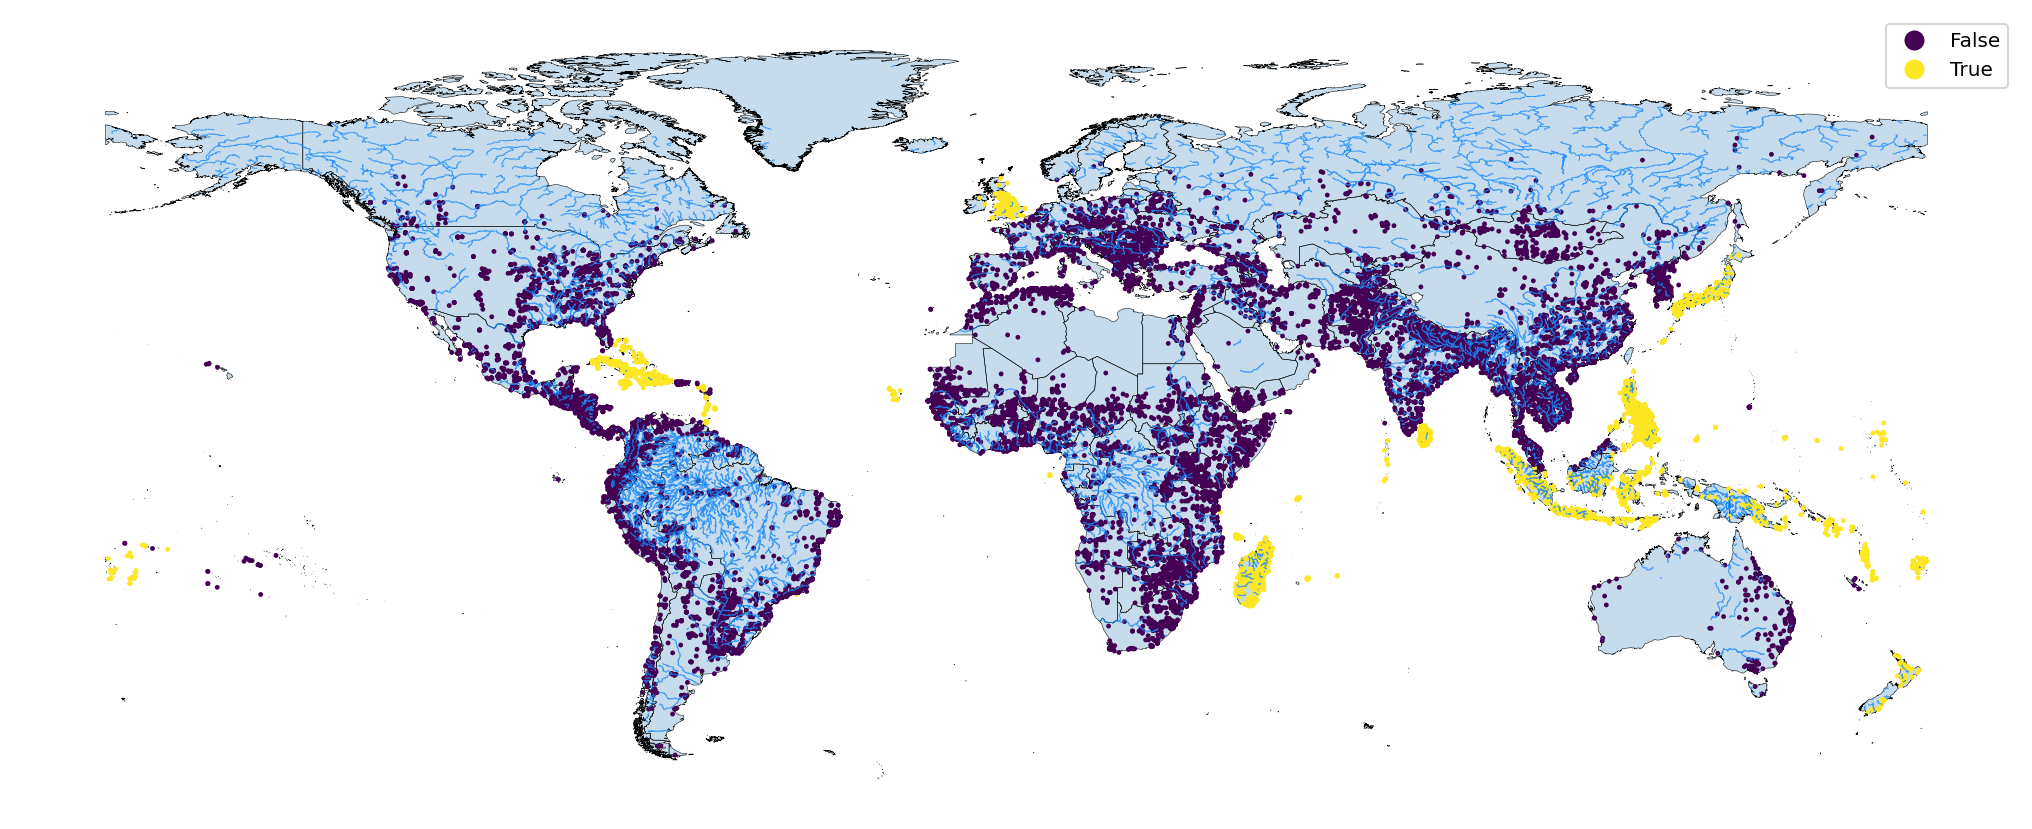

In [18]:
fig, ax = plt.subplots(figsize=(14, 9), dpi=144)
world.plot(facecolor='tab:blue', alpha=0.25, ax=ax)
world.plot(facecolor='none', edgecolor='k', lw=0.25, ax=ax)
rivers.plot(edgecolor='dodgerblue', lw=0.5, ax=ax)

data.dropna(subset='disaster_class').plot('is_island', 
                                      markersize=2, 
                                      ax=ax, 
                                      legend=True, 
                                      categorical=True,
                                      cmap='viridis')
ax.axis('off')
plt.show()

In [19]:
if modified_data:
    (data
         .drop(columns=emdat['df_raw_filtered_adj'].columns.tolist() + ['geometry'])
         .to_csv(fpath_1))

# Synthetic Data

Create a bunch of dummy datapoints with geospatial features. These will be non-disasters. The model will need to distinguish the real disaster data from these fake points.

In [20]:
if not os.path.exists(here('data/synthetic_non_disasters.csv')):
    seed = sum(map(ord, 'Laos GGGI Climate Adaptation'))
    rng = np.random.default_rng(seed)

    # "Melt" the world into 5 regions - Americas, Europe, Asia, Afria, Oceania. This corresponds with the "Regions" column from EMDAT
    simple_world = (world
                        .replace({'North America':'Americas', 'South America':'Americas'})
                        .query('CONTINENT != "Seven seas (open ocean)"')
                        .dissolve('CONTINENT')
                        .loc[data.Region.unique()])

    # For every region, sample a random point for each disaster observed in that region
    not_disasters = (simple_world
                         .sample_points(data.groupby('Region').size().values, rng=rng)
                         .explode()
                         .reset_index()
                         .rename(columns={'CONTINENT':'Region', 'sampled_points':'geometry'})
                         .set_geometry('geometry'))

    # Compute geospatial features for the artifical data
    iso_dicts = [gpd.sjoin(world.loc[[i]], not_disasters, predicate='contains')[['ISO_A3', 'index_right']].set_index('index_right').to_dict()['ISO_A3'] for i in world.index]
    island_dict = data[['ISO', 'is_island']].drop_duplicates().set_index('ISO').to_dict()['is_island']
    not_disasters = not_disasters.join(pd.Series({k:v for d in iso_dicts for k, v in d.items()}, name='ISO'))
    not_disasters['is_island'] = not_disasters['ISO'].map(island_dict.get)

    distances = get_distance_to(rivers, points=not_disasters, return_columns=['ORD_FLOW', 'HYRIV_ID']).rename(columns={'distance_to_closest':'distance_to_river'})
    not_disasters = not_disasters.join(distances).assign(distance_to_river = lambda x: x.distance_to_river / 1000)

    distances = get_distance_to(coastline.boundary, points=not_disasters, return_columns=None).rename(columns={'distance_to_closest':'distance_to_coastline'})
    not_disasters = not_disasters.join(distances).assign(distance_to_coastline = lambda x: x.distance_to_coastline / 1000)
    
    not_disasters['long'] = not_disasters.geometry.apply(lambda x: x.x)
    not_disasters['lat'] = not_disasters.geometry.apply(lambda x: x.y)
    
    # Match each synthetic datapoint with a real datapoint and save the "twin" index 
    # Use this to merge more features (start date, disaster class) onto the fake data
    not_disasters.sort_values(by=['Region', 'ISO'], inplace=True)
    not_disasters['twin_emdat_index'] = data.index.get_level_values(0)
    not_disasters['twin_location_id'] = data.index.get_level_values(1)
    not_disasters.sort_index().drop(columns=['geometry']).to_csv(here('data/synthetic_non_disasters.csv'))

else:
    not_disasters = pd.read_csv(here('data/synthetic_non_disasters.csv'))
    not_disasters['geometry'] = gpd.points_from_xy(not_disasters.long, not_disasters.lat)
    not_disasters = gpd.GeoDataFrame(not_disasters, crs=data.crs)

# Merging data

In [21]:
#Rename not_disaster columns
not_disasters.rename(columns ={ "twin_emdat_index": "emdat_index",
                              "twin_location_id": "location_id"}, inplace = True)

#Assign rando years to each fake disaster
not_disasters2 = pd.merge(not_disasters, data.groupby("ISO").Start_Year.sample( frac=1.0, replace=False), right_index= True,
         left_on= ["emdat_index", "location_id" ], how = "left" )

In [22]:
#Add the is_real columns
not_disasters2["is_disaster"] = 0
data["is_disaster"] = 1

#Concat data frames
merged_df = pd.concat([not_disasters2, data.reset_index()], ignore_index= True)

In [23]:
#Load data
all_data = load_all_data()
panel_data  = all_data["df_panel"][['population_density',
       'gdp_per_cap', 'Population', 'precip']]

co2 = all_data["df_time_series"]["co2"]

In [24]:
#Obtain precip_deviation
precipitation = all_data["gpcc"]

countries = precipitation.reset_index()["ISO"].unique()

precip_deviation = pd.DataFrame()

precip_deviation = pd.DataFrame(columns=countries)
for x in countries:
    precip_deviation[x] = (
        precipitation.reset_index().pivot(
            index="year", values="precip", columns="ISO"
        )[x]
        - pd.DataFrame(precipitation.unstack(-2).head(30).mean())
        .loc["precip"]
        .loc[x]
        .values
    )

precip_deviation = (
    precip_deviation.stack()
    .reset_index()
    .rename(columns={"level_1": "ISO", 0: "precip_deviation"})
    .set_index(["ISO", "year"])
)
precip_deviation = precip_deviation.sort_index()

In [25]:
#Obtain ocean temperature deviation
from statsmodels.tsa.seasonal import STL

df_clim = all_data["df_time_series"][["co2", "Temp", "precip"]].iloc[1:-1]

stl_ocean_temp = STL(pd.DataFrame(df_clim["Temp"].dropna()), period=3)
result_ocean_temp = stl_ocean_temp.fit()
trend_ocean_temp = result_ocean_temp.trend
dev_from_trend_ocean_temp = df_clim["Temp"].dropna() - trend_ocean_temp

dev_from_trend_ocean_temp = pd.DataFrame(dev_from_trend_ocean_temp).rename(columns= {0: "dev_ocean_temp"})

In [26]:
#Merge Data Frames
merged_df2 = pd.merge(merged_df, panel_data, left_on= ["ISO", "Start_Year"], right_index= True, how = "left")
merged_df3 = pd.merge(merged_df2, co2, left_on= ["Start_Year"], right_index= True, how = "left")
merged_df4 = pd.merge(merged_df3, precip_deviation, left_on= ["ISO", "Start_Year"], right_index= True, how = "left" )
merged_df5 = pd.merge(merged_df4, dev_from_trend_ocean_temp, left_on= ["Start_Year"], right_index= True, how = "left" )

In [27]:
#preparing data set

#Creating log variables
log_list = ["distance_to_river", "distance_to_coastline", "Total_Affected", "Total_Damage_Adjusted", "population_density",
            "gdp_per_cap"]
for y in log_list:
    merged_df5[f"log_{y}"] = np.log(merged_df5[y])


#Creating the squared log variables
merged_df5["log_population_density_squared"] = 2 *merged_df5["log_population_density"]
merged_df5["log_gdp_per_cap_squared"] = 2 * merged_df5["log_gdp_per_cap"]

/home/jesse/mambaforge/envs/laos-climate-change/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [28]:
model_list = ["Population", "co2", "precip_deviation", "dev_ocean_temp", "log_distance_to_river", 'log_distance_to_coastline',
       'log_Total_Affected', 'log_Total_Damage_Adjusted', 'log_population_density', 'log_gdp_per_cap',
       'log_population_density_squared', 'log_gdp_per_cap_squared', 
        'ISO', 'Start_Year', "is_disaster" 
             ]

model_df = merged_df5[model_list].dropna()

# Model helper functions

In [29]:
# Standardize function
def standardize(df: pd.DataFrame):
    df_standardized = (df - df.mean())/df.std()
    return df_standardized

In [109]:
import pytensor

#Define data function
def add_data(features: list[str], df: pd.DataFrame, add_time :bool = False, target: str | None = None, name = None, dims=None, dtype=None):
    X_name = 'X' if name is None else f'X_{name}'
    Y_name = 'Y' if name is None else f'Y_{name}'
    
    if dtype is None:
        dtype = pytensor.config.floatX
        
    with pm.modelcontext(None):
        X = pm.Data(X_name, df[features].astype(dtype), dims=dims)
        
        if target is not None:
            Y = pm.Data(Y_name, df[target].astype(dtype), dims=dims[0] if dims is not None else dims)
            return X, Y
        
    return X

#Add country fixed effect function
def add_country_effect():
    with pm.modelcontext(None):
        country_effect_mu = pm.Normal('country_effect_mu', mu = 0, sigma = 1)
        country_effect_scale = pm.Gamma('country_effect_scale', alpha=2, beta=1)
        country_effect_offset = pm.ZeroSumNormal('country_effect_offset', sigma=1, dims="ISO")
        country_effect = pm.Deterministic('country_effect', country_effect_mu + country_effect_scale * country_effect_offset, dims="ISO")
        
    return country_effect


In [110]:
# Function to create plot inputs
def generate_plot_inputs(idata):
    #Extract predictions
    predictions = idata.posterior_predictive['y_hat'].mean(dim=['chain', 'draw'])
    predictions = predictions.to_dataframe().drop(columns = ["ISO"]).reset_index().rename(columns = {"y_hat": "predictions"})

    hdi_mean = az.hdi(idata.posterior_predictive.y_hat)

    hdi = hdi_mean['y_hat'].to_dataframe().drop(columns = ["ISO"]).reset_index()

    hdi_mean_50 = az.hdi(idata.posterior_predictive.y_hat, hdi_prob=.5)
    
    hdi_50 = hdi_mean_50['y_hat'].to_dataframe().drop(columns = ["ISO"]).reset_index()

    #Merge results and predictions in one df
    df_predictions = df[[ "ISO"]]

    #95% HDI
    df_predictions = ( pd.merge(df_predictions,  hdi.query('hdi == "lower"')[["ISO", "y_hat"]] , 
             left_on= ["ISO"], right_on= ["ISO"], how = "left")
                     .rename(columns = {"y_hat": "lower_y_hat_95"}))
    df_predictions = (pd.merge(df_predictions, hdi.query('hdi == "higher"')[["ISO",  "y_hat"]] ,
         left_on= ["ISO"], right_on= ["ISO"], how = "left")
                     .rename(columns = {"y_hat": "higher_y_hat_95"}))
    #50% HDI
    df_predictions = ( pd.merge(df_predictions,  hdi_50.query('hdi == "lower"')[["ISO",  "y_hat"]] , 
             left_on= ["ISO"], right_on= ["ISO"], how = "left")
                     .rename(columns = {"y_hat": "lower_y_hat_50"}))
    df_predictions = (pd.merge(df_predictions, hdi_50.query('hdi == "higher"')[["ISO", "y_hat"]] ,
         left_on= ["ISO"], right_on= ["ISO"], how = "left")
                     .rename(columns = {"y_hat": "higher_y_hat_50"}))
    
    #Predictions
    df_predictions = (pd.merge(df_predictions, predictions ,
             left_on= ["ISO"], right_on= ["ISO"], how = "left")
             .rename(columns = {"y_hat": "predictions"}))
    
    return df_predictions

In [111]:
#Plotting function
def plotting_function(idata, country: str):
    df_predictions = generate_plot_inputs(idata = idata)

    #Filter country
    data = df_predictions.query("ISO == @country")
    
    fig, ax = plt.subplots()
    ax.plot(data["year"], data["predictions"], zorder=1000, color='tab:red', label='Mean Predicted Disaster Count')
    ax.scatter(data["year"], data["is_disaster"], color='k', label='Actual prob')
    ax.fill_between(data["year"], data["higher_y_hat_95"], data["lower_y_hat_95"], alpha=0.25, color='tab:blue', label='95% HDI')
    ax.fill_between(data["year"], data["lower_y_hat_50"], data["higher_y_hat_50"], alpha=0.5, color='tab:blue', label='50% HDI')
    ax.legend(loc='upper left')

    #plt.title(f"{country} disaster count and predictions")

    plt.xlabel("Year")
    plt.ylabel("Disaster Count")
    
    plt.show();
    

In [112]:
def plot_ppc_loopit(idata, title):
    fig = plt.figure(figsize=(12,9))
    ax_ppc = fig.add_subplot(211)
    ax1 = fig.add_subplot(223); ax2 = fig.add_subplot(224)
    az.plot_ppc(idata, ax=ax_ppc);
    for ax, ecdf in zip([ax1, ax2], (False, True)):
        az.plot_loo_pit(idata, y="y_hat", ecdf=ecdf, ax=ax);
    ax_ppc.set_title(title)
    ax_ppc.set_xlabel("")
    return np.array([ax_ppc, ax1, ax2])

# Creating Laos grid

In [246]:
def create_grid_from_shape(shapefile, rivers, coastline, grid_size = 100):
    long_min, lat_min, long_max, lat_max = shapefile.dissolve().bounds.values.ravel()
    long_grid = np.linspace(long_min, long_max, grid_size)
    lat_grid = np.linspace(lat_min, lat_max, grid_size)

    grid = np.column_stack([x.ravel() for x in np.meshgrid(long_grid, lat_grid)])
    grid = gpd.GeoSeries(gpd.points_from_xy(*grid.T), crs='EPSG:4326')
    grid = gpd.GeoDataFrame({'geometry': grid})

    point_overlay = grid.overlay(shapefile, how='intersection')
    points = point_overlay.geometry
    points = points.to_frame().assign(long = lambda x: x.geometry.x, lat = lambda x: x.geometry.y)
    
    #Obtain distance with rivers
    distances_to_rivers = (get_distance_to(rivers, points=points, return_columns=['ORD_FLOW', 'HYRIV_ID'])
                           .rename(columns={'distance_to_closest':'distance_to_river'}))

    points = pd.merge(points, distances_to_rivers, left_index= True, right_index= True, how = "left")
    
    #Obtain Laos distance with coastlines
    distances_to_coastlines = (get_distance_to(coastline.boundary, points=points, return_columns=None)
                              .rename(columns={'distance_to_closest':'distance_to_coastline'}))

    points =  pd.merge(points, distances_to_coastlines, left_index= True, right_index= True, how = "left")
    
    #Create log of distances
    points = points.assign(log_distance_to_river = lambda x: np.log(x.distance_to_river),
                           log_distance_to_coastline = lambda x: np.log(x.distance_to_coastline))
    
    if 'ISO_A3' in point_overlay.columns:
        points['ISO'] = point_overlay.ISO_A3
    else:
        points['ISO'] = 'LAO'
        
    return points

In [378]:
laos_points = create_grid_from_shape(laos, rivers, coastline, grid_size=100)

#Assign is_island column
laos_points["is_island"] = False

  0%|          | 0/2980 [00:00<?, ?it/s]

  0%|          | 0/2980 [00:00<?, ?it/s]

#Save data
laos_points.to_csv("../data/laos_points.csv")
merged_df5.to_csv("../data/HSGP_model_data.csv")

#Load data:
laos_points = pd.read_csv("../data/laos_points.csv")
merged_df5 = pd.read_csv("../data/HSGP_model_data.csv")

# Losgistic regression Full HSGP geo-model

In [117]:
#Delimiting data set
model_list_2 = ['ISO', 'Start_Year', "is_disaster", 'log_distance_to_river', 'log_distance_to_coastline',
                'is_island', "lat", "long" ]


distance_features_2 = ['log_distance_to_river', 'log_distance_to_coastline', 'is_island']

time_varying_features_2 = ["Population", "co2", "precip_deviation", "dev_ocean_temp", 'log_population_density', 'log_population_density_squared',
             'log_gdp_per_cap', 'log_gdp_per_cap_squared']

model_df_2 = merged_df5[model_list_2 + time_varying_features_2].dropna()

In [118]:
#Define cooords
is_disaster_idx , is_disaster = pd.factorize(model_df_2["is_disaster"])
ISO_idx, ISO = pd.factorize(model_df_2["ISO"]) 
obs_idx = model_df_2.index
gp_features = ["lat", "long"]

#Creating idx
xr_idx = xr.Coordinates.from_pandas_multiindex(model_df_2.set_index(['ISO', 'Start_Year']).index, 'obs_idx')

#Set coords
coords_2 = {"is_disaster" : is_disaster,
        "obs_idx": obs_idx,
        "ISO": ISO,
        "distance_features": distance_features_2,
        "time_varying_features" : time_varying_features_2,
        "gp_feature":gp_features }


In [145]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

pipeline = ColumnTransformer([('standardize', StandardScaler(), ['log_distance_to_river', 'log_distance_to_coastline'] + time_varying_features_2)],
                            remainder='passthrough')
model_data = pd.DataFrame(pipeline.fit_transform(model_df_2),
                          index=model_df_2.index,
                          columns=[x.split('__')[-1] for x in pipeline.get_feature_names_out()])

In [379]:
gp.prior_linearized??

In [148]:
floatX = pytensor.config.floatX

with pm.Model(coords=coords_2) as HSGP_full_model:
    #Declare data
    geographic_data, Y = add_data(features= distance_features_2,  
                                  target = "is_disaster", 
                                  df = model_data, 
                                  dims=['obs_idx', 'features'])
    economic_data = add_data(features = time_varying_features_2,  
                             target = None, 
                             df = model_data, 
                             name='time_varying',
                             dims=['obs_idx', 'time_varying_features'])
    
    X_gp = pm.Data("X_gp", model_data[["lat", "long"]].astype(floatX), 
                   dims=['obs_idx', 'gp_feature'])
    iso_idx_pt = pm.Data('ISO_idx', ISO_idx, dims=['obs_idx'])

    #Country effect
#     country_effect = pm.Normal("country_effect", mu = 0, sigma =1, dims = ["ISO"])
    country_effect = add_country_effect()

    #Betas
    geographic_betas = pm.Normal("geographic_betas", mu = 0, sigma = 1, dims = ["distance_features"])
    economic_betas = pm.Normal("economic_betas", mu = 0, sigma = 1, dims = ["time_varying_features"])

    # Prior on the HSGP
    eta = pm.Exponential("eta", scale=2.0)
    ell_params = pm.find_constrained_prior(
        pm.Lognormal, lower=0.5, upper=10.0, mass=0.95, init_guess={"mu": 1.0, "sigma": 1.0}
    )
    ell = pm.Lognormal("ell", **ell_params, dims=["gp_feature"])
    cov_func = eta**2 * pm.gp.cov.Matern52(input_dim=2, ls=ell)

    m0, m1, c = 20, 20, 1.5
    gp = pm.gp.HSGP(m=[m0, m1], c=c, cov_func=cov_func)

    phi, sqrt_psd = gp.prior_linearized(X=X_gp)

    basis_coeffs = pm.Normal("basis_coeffs", size=gp.n_basis_vectors)
#     HSGP_component = pm.Deterministic("HSGP_component", (phi * (basis_coeffs * sqrt_psd).sum(axis=-1)).sum(axis=-1), dims=['obs_idx'])
#     geographic_component = pm.Deterministic('geographic_component', (geographic_data * geographic_betas).sum(axis=-1), dims=['obs_idx'])
#     economic_component = pm.Deterministic('economic_component', (economic_data * economic_betas).sum(axis=-1), dims=['obs_idx'])
    HSGP_component = phi @ (basis_coeffs * sqrt_psd)
    geographic_component = geographic_data @ geographic_betas
    economic_component = economic_data @ economic_betas
    
    #Model mu
#     logit_p = pm.Deterministic('logit_p', country_effect[iso_idx_pt] + geographic_component + economic_component + HSGP_component, dims=['obs_idx'])
    logit_p = country_effect[iso_idx_pt] + geographic_component + economic_component + HSGP_component

    y_hat = pm.Bernoulli('y_hat', logit_p = logit_p, observed=Y, dims='obs_idx')
    HSGP_full_model_idata = pm.sample(nuts_sampler='numpyro', 
                      nuts_sampler_kwargs={'chain_method':'vectorized'},
                      chains=4, 
                      draws=500)

/home/jesse/mambaforge/envs/laos-climate-change/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:68: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype, copy=copy, device=device)
/home/jesse/mambaforge/envs/laos-climate-change/lib/python3.11/site-packages/pytensor/link/jax/dispatch/tensor_basic.py:174: UserWarning: Explicitly requested dtype int64 requested in array is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return jnp.array(x, dtype=op.dtype)
/home/jesse/mambaforge/envs/laos-climate-change/lib/python3

  0%|                                                                                          | 0/1500 [00:00<?, ?it/s]/home/jesse/mambaforge/envs/laos-climate-change/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:68: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype, copy=copy, device=device)
/home/jesse/mambaforge/envs/laos-climate-change/lib/python3.11/site-packages/pytensor/link/jax/dispatch/tensor_basic.py:174: UserWarning: Explicitly requested dtype int64 requested in array is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#cur

sample: 100%|███████████████████████████████████████████████████████████████████████| 1500/1500 [49:32<00:00,  1.98s/it]
/home/jesse/mambaforge/envs/laos-climate-change/lib/python3.11/site-packages/pytensor/link/jax/dispatch/tensor_basic.py:174: UserWarning: Explicitly requested dtype int64 requested in array is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return jnp.array(x, dtype=op.dtype)
/home/jesse/mambaforge/envs/laos-climate-change/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:68: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  

In [43]:
# from pymc.model.transform.optimization import freeze_dims_and_data
# compiled_model = nutpie.compile_pymc_model(freeze_dims_and_data(HSGP_full_model), backend="jax", gradient_backend='jax')
# HSGP_full_model_idata = nutpie.sample(compiled_model)

In [44]:
#Save the idata
# az.to_netcdf(data = HSGP_full_model_idata, filename= pathlib.Path("HSGP_full_model_idata"))

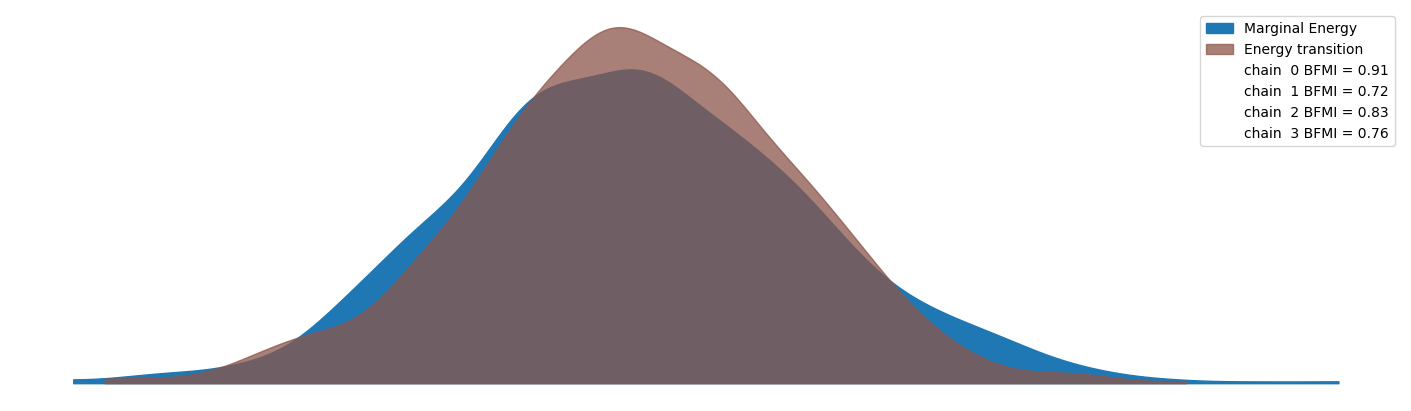

In [149]:
az.plot_energy(HSGP_full_model_idata);

In [150]:
print(az.summary(HSGP_full_model_idata, var_names=[ 'geographic_betas', 'economic_betas', 'eta', 'ell']).to_string())

                                                  mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
geographic_betas[log_distance_to_river]         -0.250  0.022  -0.291   -0.210      0.000    0.000    3573.0    1500.0   1.00
geographic_betas[log_distance_to_coastline]     -0.907  0.037  -0.977   -0.838      0.001    0.000    3899.0    1636.0   1.00
geographic_betas[is_island]                     -0.399  0.935  -2.048    1.487      0.035    0.025     728.0     975.0   1.02
economic_betas[Population]                      -3.063  0.266  -3.588   -2.588      0.006    0.004    2073.0    1680.0   1.00
economic_betas[co2]                              0.139  0.047   0.050    0.222      0.001    0.001    1287.0    1714.0   1.00
economic_betas[precip_deviation]                 0.101  0.025   0.055    0.146      0.000    0.000    3396.0    1572.0   1.00
economic_betas[dev_ocean_temp]                   0.289  0.016   0.259    0.318      0.000    0.000    3655.0    1310.0

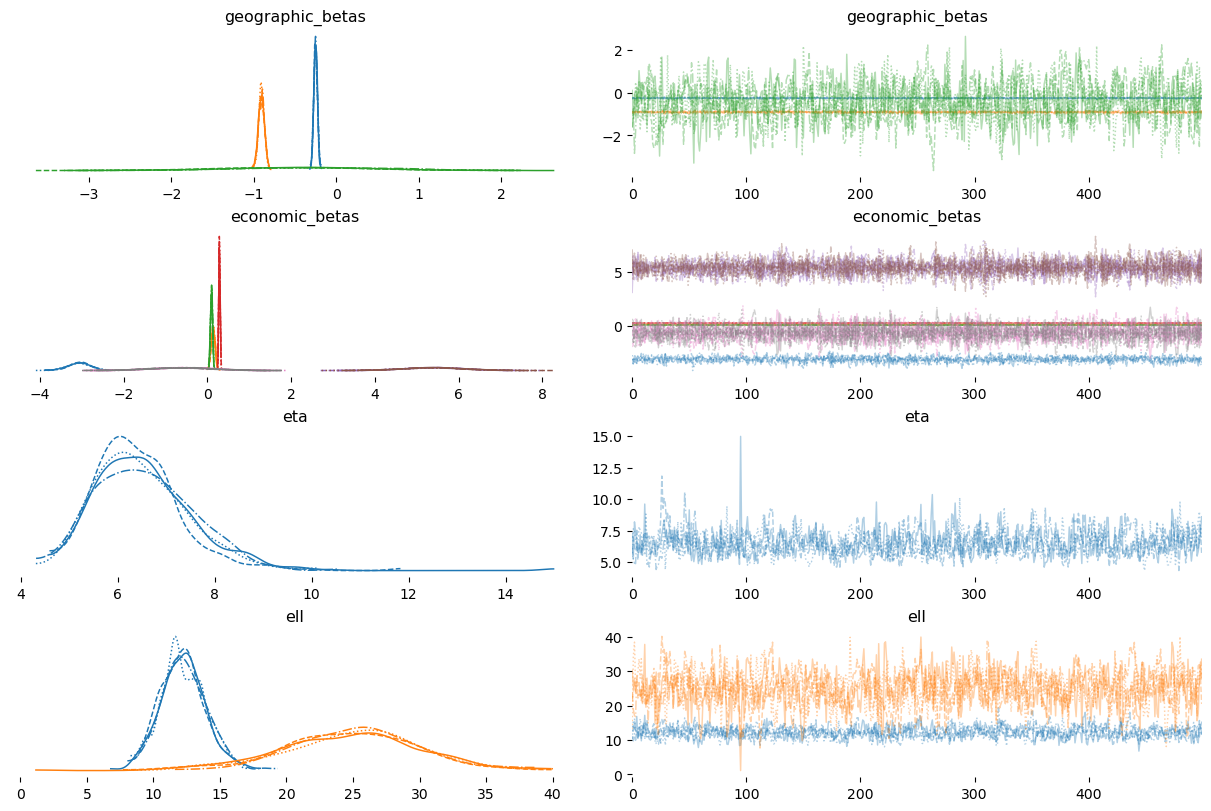

In [151]:
az.plot_trace(HSGP_full_model_idata, var_names=[ 'geographic_betas', 'economic_betas', 'eta', 'ell']);

In [152]:
laos_grid_2d = np.array(laos_points[["lat", "lon"]])

In [153]:
laos_data_by_year = model_df_2.query('ISO == "LAO"')[time_varying_features_2 + ['Start_Year']].drop_duplicates().set_index('Start_Year').sort_index()

In [381]:
ref_year = '2020'
laos_idx = ISO.tolist().index('LAO')
laos_points = laos_points.assign(ISO = 'LAO', Start_Year = f'{ref_year}-01-01', is_disaster=0)
laos_points = laos_points.rename(columns={'lon':'long'})

laos_data_by_year.loc[ref_year]
for col in time_varying_features_2:
    laos_points[col] = laos_data_by_year.loc[ref_year, col].item()


In [382]:
laos_plot_data = pd.DataFrame(pipeline.transform(laos_points),
                              index=laos_points.index,
                              columns=[x.split('__')[-1] for x in pipeline.get_feature_names_out()])

In [383]:
def compute_center(X):
    return (pt.max(X, axis=0) + pt.min(X, axis=0)).eval() / 2

In [384]:
from copy import deepcopy
from pymc.model.transform.optimization import freeze_dims_and_data
plot_coords = deepcopy(coords_2)
plot_coords['obs_idx'] = np.arange(laos_plot_data.shape[0])

with pm.Model(coords=plot_coords) as HSGP_full_model_plot:
    geographic_data = add_data(features= distance_features_2 ,  target = None, df =  laos_plot_data, dims=['obs_idx', 'features'])
    economic_data = add_data(features = time_varying_features_2 ,  target = None, df =  laos_plot_data, name='time_varying', dims=['obs_idx', 'time_varying_features'])
    X_gp = pm.Data("X_gp", laos_plot_data[["lat", "long"]].astype(floatX), dims=['obs_idx', 'gp_feature'])

    #Country effect
    country_effect = pm.Flat("country_effect", dims = ["ISO"])    

    #Betas
    geographic_betas = pm.Flat("geographic_betas", dims = ["distance_features"])
    economic_betas = pm.Flat("economic_betas", dims = ["time_varying_features"])

    # Prior on the HSGP
    eta = pm.Flat("eta")
    ell = pm.Flat("ell", dims=["gp_feature"])
    cov_func = eta**2 * pm.gp.cov.Matern52(input_dim=2, ls=ell)

    m0, m1, c = 20, 20, 1.5
    gp = pm.gp.HSGP(m=[m0, m1], c=c, cov_func=cov_func)
    gp._X_center = compute_center(model_data[["lat", "long"]].astype(floatX))

    phi, sqrt_psd = gp.prior_linearized(X=X_gp)

    basis_coeffs = pm.Flat("basis_coeffs", size=gp.n_basis_vectors)

    HSGP_component = pm.Deterministic('HSGP_component', phi @ (basis_coeffs * sqrt_psd), dims=['obs_idx'])
    geographic_component = pm.Deterministic('geographic_component', geographic_data @ geographic_betas, dims=['obs_idx'])
    economic_component = pm.Deterministic('economic_component', economic_data @ economic_betas, dims=['obs_idx'])
    
    logit_p = pm.Deterministic('logit_p', country_effect[laos_idx] + geographic_component + economic_component + HSGP_component, dims=['obs_idx'])
    p = pm.Deterministic('p', pm.math.invlogit(logit_p), dims=['obs_idx'])
    
    
with freeze_dims_and_data(HSGP_full_model_plot):
    idata_plot = pm.sample_posterior_predictive(HSGP_full_model_idata, extend_inferencedata=False, compile_kwargs={'mode':'JAX'},
                                                var_names=['HSGP_component', 'geographic_component', 'economic_component', 'logit_p', 'p'])

Sampling: []


Output()

/home/jesse/mambaforge/envs/laos-climate-change/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:68: 
UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to 
dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell 
environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype, copy=copy, device=device)

In [385]:
#Store df of predictions
HSGP_full_model_predictions = idata_plot.posterior_predictive.mean(dim=("chain", "draw")).to_dataframe()

#Merge predictions with Laos points
HSGP_full_model_predictions = pd.merge(HSGP_full_model_predictions, laos_points, 
                                       left_index=True, right_index=True,
                                       how = "left")

#Transform into geo Data Frame
HSGP_full_model_predictions_geo = gpd.GeoDataFrame(
                HSGP_full_model_predictions,
    geometry=gpd.points_from_xy(HSGP_full_model_predictions["long"],
                                HSGP_full_model_predictions["lat"]),crs="EPSG:4326"
            )

In [386]:
# with HSGP_full_model:
#     pm.set_data({'X': laos_plot_data[distance_features_2].values.astype(float),
#                  'Y': np.zeros(laos_plot_data.shape[0]),
#                  'X_time_varying': laos_plot_data[time_varying_features_2].values.astype(float),
#                  'X_gp': laos_plot_data[['lat', 'long']].astype(float).values,
#                  'ISO_idx':np.full(laos_plot_data.shape[0], laos_idx)},
#                 coords={'obs_idx': laos_plot_data.index.values})
# with freeze_dims_and_data(HSGP_full_model):
#     idata_laos = pm.sample_posterior_predictive(HSGP_full_model_idata, extend_inferencedata=False, compile_kwargs={'mode':'JAX'})

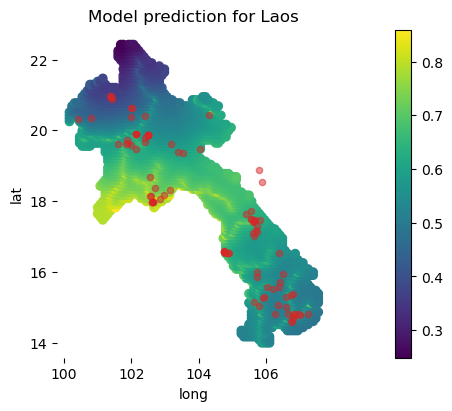

In [387]:
#Plot the predictions
fig, ax = plt.subplots()
HSGP_full_model_predictions_geo.plot("p",legend=True, ax=ax)
model_df_2.query('ISO == "LAO" & is_disaster == 1').plot.scatter(x='long', y='lat', ax=ax, c='tab:red', alpha=0.5)
plt.title("Model prediction for Laos", );

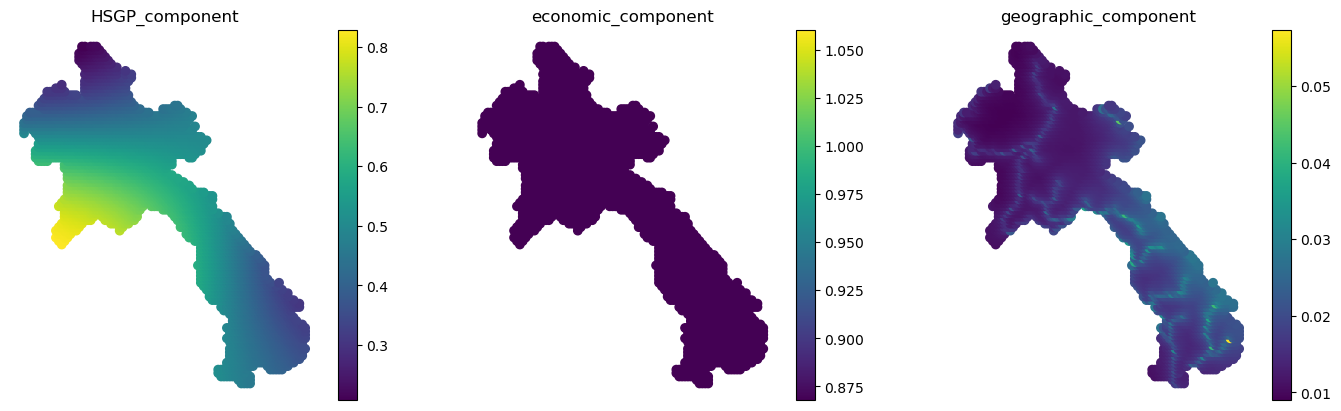

In [388]:
from scipy.special import expit
fig, ax = plt.subplots(1, 3, figsize=(14, 4))
for name, axis in zip(['HSGP_component', 'economic_component', 'geographic_component'], fig.axes):
    temp = expit(idata_plot.posterior_predictive[name]).mean(dim=['chain', 'draw']).to_dataframe()
    temp = pd.merge(temp, laos_points, 
                                       left_index=True, right_index=True,
                                       how = "left")

    #Transform into geo Data Frame
    temp = gpd.GeoDataFrame(
                    temp,
        geometry=gpd.points_from_xy(HSGP_full_model_predictions["long"],
                                    HSGP_full_model_predictions["lat"]),crs="EPSG:4326"
                )
    temp.plot(name, legend=True, ax=axis)
    axis.set_title(name)
    axis.axis('off')
plt.show()

# South-East Asis

In [285]:
sea_codes = ['BRN', 'KHM', 'IDN', 'LAO', 'MYS', 'MMR', 'PHL', 'SGP', 'THA', 'TLS', 'VNM']
SEA = world.query('ISO_A3 in @sea_codes')
sea_points = create_grid_from_shape(SEA, rivers, coastline, grid_size=200)

  0%|          | 0/7582 [00:00<?, ?it/s]

  0%|          | 0/7582 [00:00<?, ?it/s]

In [389]:
ref_year = '2020'
sea_points = sea_points.assign(Start_Year = pd.to_datetime(f'{ref_year}-01-01'), 
                               is_disaster=0,
                               is_island = lambda x: x.ISO.apply(island_dict.get))
sea_points_merged = pd.merge(sea_points, 
                             model_df_2[time_varying_features_2 + ['ISO', 'Start_Year']].drop_duplicates(), 
                             left_on=['ISO', 'Start_Year'],
                             right_on=['ISO', 'Start_Year'],
                             how='left')
sea_points_merged = pd.DataFrame(pipeline.transform(sea_points_merged),
                                 index=sea_points_merged.index,
                                 columns=[x.split('__')[-1] for x in pipeline.get_feature_names_out()])
sea_iso_idx = sea_points_merged.ISO.apply(lambda x: ISO.tolist().index(x) if x in ISO else None)
missing = sea_iso_idx.isna()
sea_points_merged = sea_points_merged.loc[~missing]
sea_iso_idx = sea_iso_idx[~missing].astype(int)
# for col in time_varying_features_2:
#     laos_points[col] = laos_data_by_year.loc[ref_year, col].item()

# laos_points = laos_points.assign(ISO = 'LAO', Start_Year = f'{ref_year}-01-01', is_disaster=0)
# laos_points = laos_points.rename(columns={'lon':'long'})

# laos_data_by_year.loc[ref_year]
# for col in time_varying_features_2:
#     laos_points[col] = laos_data_by_year.loc[ref_year, col].item()


In [391]:
from copy import deepcopy
from pymc.model.transform.optimization import freeze_dims_and_data
plot_coords = deepcopy(coords_2)
plot_coords['obs_idx'] = np.arange(sea_points_merged.shape[0])

with pm.Model(coords=plot_coords) as HSGP_full_model_plot:
    geographic_data = add_data(features= distance_features_2 ,  target = None, df =  sea_points_merged, dims=['obs_idx', 'features'])
    economic_data = add_data(features = time_varying_features_2 ,  target = None, df =  sea_points_merged, name='time_varying', dims=['obs_idx', 'time_varying_features'])
    X_gp = pm.Data("X_gp", sea_points_merged[["lat", "long"]].astype(floatX), dims=['obs_idx', 'gp_feature'])
    iso_idx_pt = pm.Data('iso_idx_pt', sea_iso_idx.values, dims=['obs_idx'])
    
    #Country effect
    country_effect = pm.Flat("country_effect", dims = ["ISO"])    

    #Betas
    geographic_betas = pm.Flat("geographic_betas", dims = ["distance_features"])
    economic_betas = pm.Flat("economic_betas", dims = ["time_varying_features"])

    # Prior on the HSGP
    eta = pm.Flat("eta")
    ell = pm.Flat("ell", dims=["gp_feature"])
    cov_func = eta**2 * pm.gp.cov.Matern52(input_dim=2, ls=ell)

    m0, m1, c = 20, 20, 1.5
    gp = pm.gp.HSGP(m=[m0, m1], c=c, cov_func=cov_func)
    gp._X_center = compute_center(model_data[['lat', 'long']].values.astype(floatX))

    phi, sqrt_psd = gp.prior_linearized(X=X_gp)

    basis_coeffs = pm.Flat("basis_coeffs", size=gp.n_basis_vectors)

    HSGP_component = pm.Deterministic('HSGP_component', phi @ (basis_coeffs * sqrt_psd), dims=['obs_idx'])
    geographic_component = pm.Deterministic('geographic_component', geographic_data @ geographic_betas, dims=['obs_idx'])
    economic_component = pm.Deterministic('economic_component', economic_data @ economic_betas, dims=['obs_idx'])
    
    logit_p = pm.Deterministic('logit_p', country_effect[iso_idx_pt] + geographic_component + economic_component + HSGP_component, dims=['obs_idx'])
    p = pm.Deterministic('p', pm.math.invlogit(logit_p), dims=['obs_idx'])

with freeze_dims_and_data(HSGP_full_model_plot):
    idata_plot_SEA = pm.sample_posterior_predictive(HSGP_full_model_idata, extend_inferencedata=False, compile_kwargs={'mode':'JAX'},
                                                var_names=['HSGP_component', 'geographic_component', 'economic_component', 'logit_p', 'p'])

Sampling: []


Output()

/home/jesse/mambaforge/envs/laos-climate-change/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:68: 
UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to 
dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell 
environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype, copy=copy, device=device)

In [392]:
idx = xr.Coordinates.from_pandas_multiindex(pd.MultiIndex.from_frame(sea_points_merged[['long', 'lat']]), 'obs_idx')

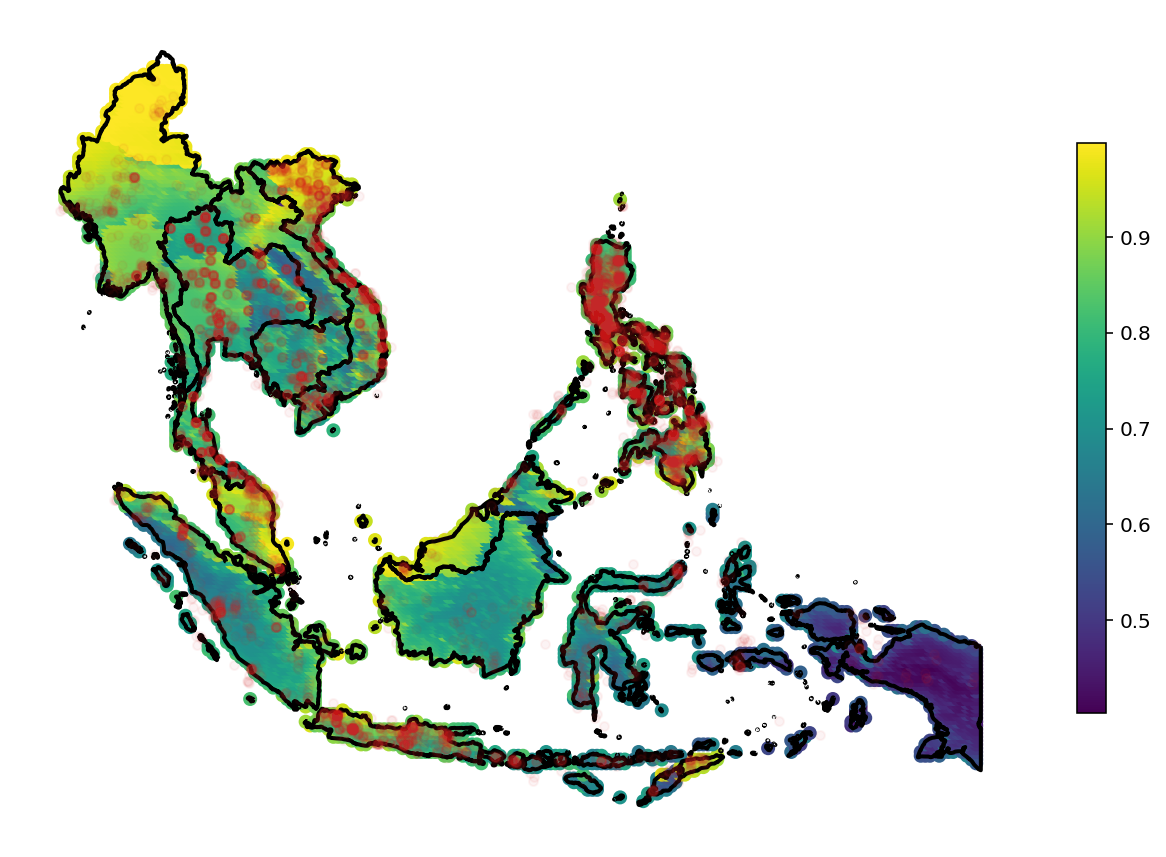

In [407]:
# fig, ax = plt.subplots(figsize=(8, 8), dpi=144, subplot_kw={'aspect':'equal'})
#Store df of predictions
sea_preds = idata_plot_SEA.posterior_predictive.mean(dim=("chain", "draw")).to_dataframe()

#Merge predictions with Laos points
sea_preds = pd.merge(sea_preds, sea_points_merged, 
                     left_index=True, right_index=True,
                     how = "left")

#Transform into geo Data Frame
sea_preds_geo = gpd.GeoDataFrame(
                sea_preds,
    geometry=gpd.points_from_xy(sea_preds["long"],
                                sea_preds["lat"]),crs="EPSG:4326"
            )

fig, ax = plt.subplots(figsize=(8, 8), dpi=144, subplot_kw={'aspect':'equal'})
sea_preds_geo.plot('p', legend=True, ax=ax, legend_kwds={'shrink':0.5})
SEA.plot(facecolor='none', edgecolor='k', lw=2, ax=ax)
data.query('is_disaster == 1 & ISO in @sea_codes').plot.scatter(x='long', y='lat', color='tab:red', alpha=0.05, ax=ax)
ax.axis('off')
plt.show()

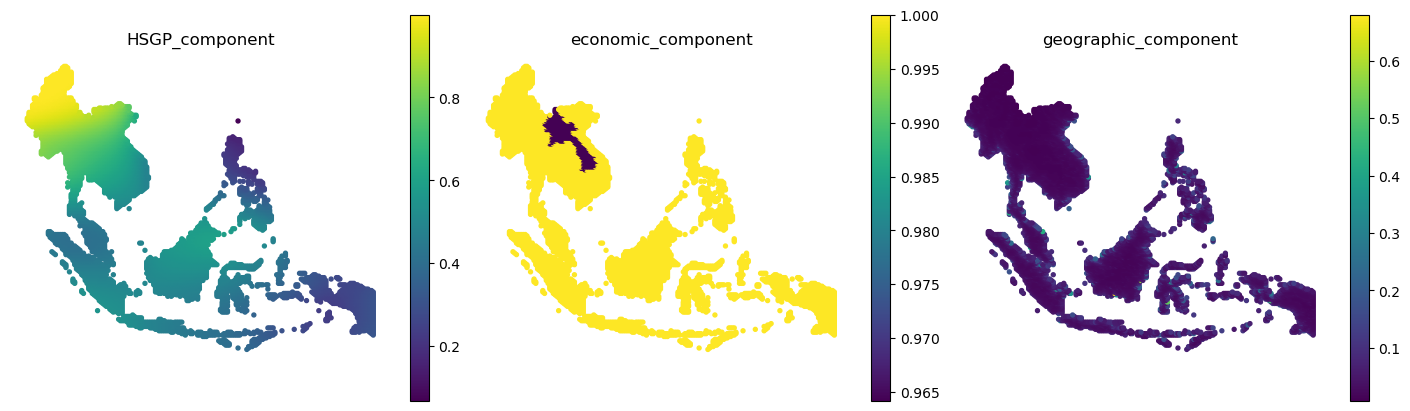

In [409]:
from scipy.special import expit
fig, ax = plt.subplots(1, 3, figsize=(14, 4))
for name, axis in zip(['HSGP_component', 'economic_component', 'geographic_component'], fig.axes):
    temp = expit(idata_plot_SEA.posterior_predictive[name]).mean(dim=['chain', 'draw']).to_dataframe()
    temp = pd.merge(temp, sea_points_merged, 
                                       left_index=True, right_index=True,
                                       how = "left")

    #Transform into geo Data Frame
    temp = gpd.GeoDataFrame(
                    temp,
        geometry=gpd.points_from_xy(sea_points_merged["long"],
                                    sea_points_merged["lat"]),crs="EPSG:4326"
                )
    temp.plot(name, legend=True, ax=axis, markersize=8)
    axis.set_title(name)
    axis.axis('off')
plt.show()